In [29]:
import numpy as np
import jax.numpy as jnp
import jax
import math

from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power, print_polynomial, build_powers
from utils.function_utils import integrate_taylor_polynomial, derivative_t_polynomial, derivative_alpha_polynomial, taylor_expand_2d, matching_coeffs

from utils.distribution_utils import construct_pdf, construct_cdf

# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot


[[ 1.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.   0. ]]
[ 1.  -0.5  0. ]
0.5


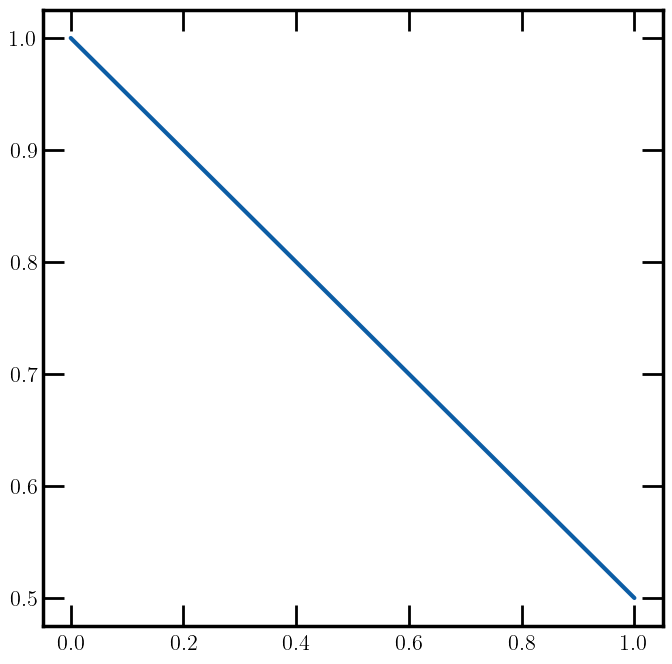

In [120]:
# Parameters of the derivative
c_mn = jnp.array(((0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0),
                  (0.0, 0.0, 0.0, -0.5, 0.0, 0.0),
                  (0.0, 0.0, 0.0, 0.0, 0.0, 0)))

M = c_mn.shape[0] - 1
N = c_mn.shape[1] - 1



# Function to collapse c_mn to c_m
def collapse_2d_coeffs(t, params):

    M, N = params.shape
    t_powers = build_powers(t, N) 
    return params @ t_powers

# If there are no zeroes in the first M rows and N columns, we can reduce the order of the polynomial by dividing by alpha^M and t^N
def reduce_order(c_mn):

    first_nonzero_m = 0
    for m in range(M):
        if np.any(c_mn[m, :] != 0):
            first_nonzero_m = m
            break

    first_nonzero_n = 0
    for n in range(N):
        if np.any(c_mn[:, n] != 0):
            first_nonzero_n = n
            break

    return c_mn[first_nonzero_m:, first_nonzero_n:], first_nonzero_m, first_nonzero_n


def eval(alpha, params):

    M = params.shape[0]
    alpha_powers = build_powers(alpha, M) 
    return alpha_powers @ params    


c_mn_reduced, num_alphas, num_ts  = reduce_order(c_mn)
c_m_reduced = collapse_2d_coeffs(1.0, c_mn_reduced)

M_reduced = c_mn_reduced.shape[0] - 1
N_reduced = c_mn_reduced.shape[1] - 1

print(c_mn_reduced)
print(c_m_reduced)
print(eval(1.0, c_m_reduced))

# Plot the function as a function of alpha
alphas = np.linspace(0, 1, 100)
vmapped_eval = jax.vmap(eval, in_axes=(0, None))
c_alpha = vmapped_eval(alphas, c_m_reduced)
plt.plot(alphas, c_alpha)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


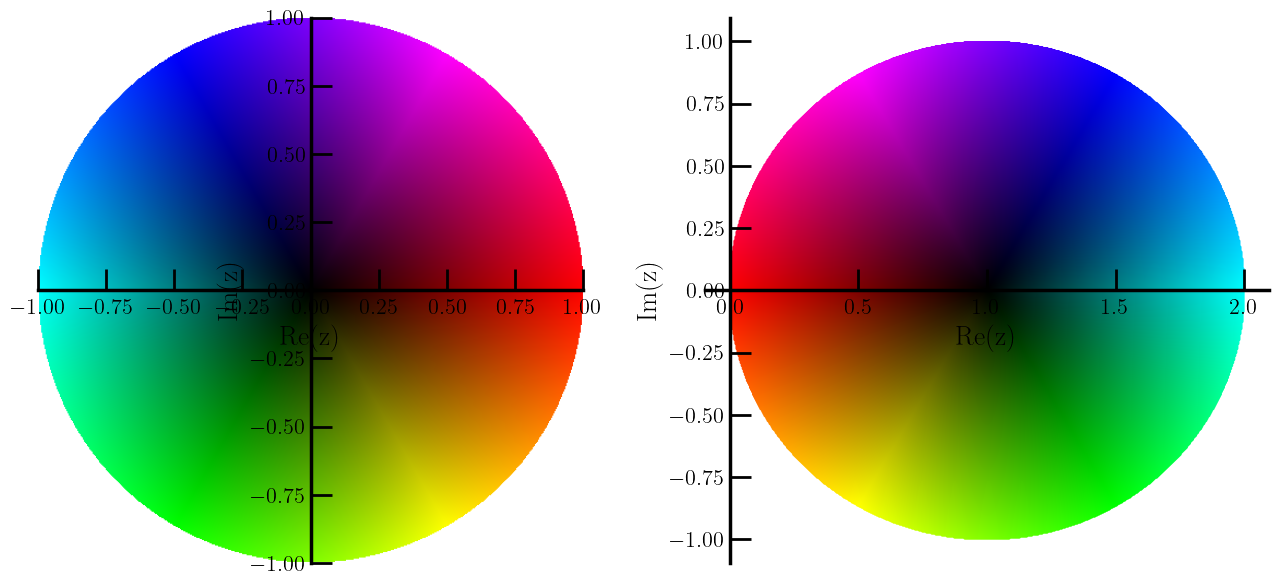

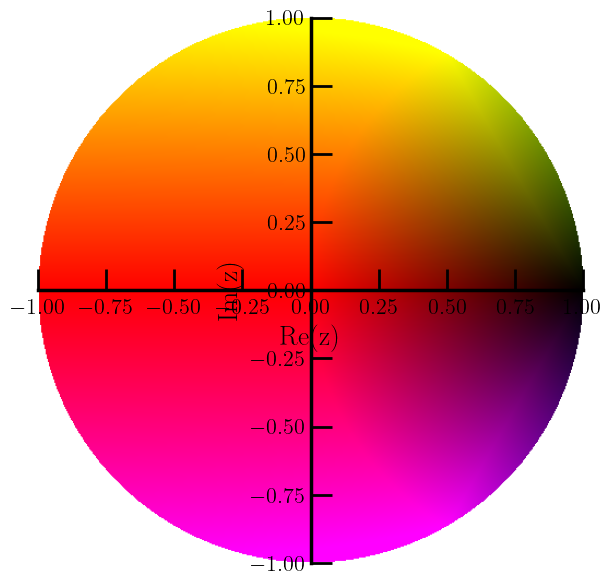

In [135]:
from matplotlib.colors import hsv_to_rgb

def complex_to_hsv(z):
    # Compute hue from the argument (angle) of z.
    hue = (np.angle(z) / (2 * np.pi)) % 1.0  # scaled to [0, 1]
    sat = np.ones_like(z.real)  # full saturation
    val = np.abs(z)             # brightness = |z|
    return hue, sat, val


def plot_complex_function(f, *args):

    # Grid resolution
    N = 500

    # Create a grid in the square [-1,1] x [-1,1]
    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j * Y

    # Create a mask for the unit disk (|z| <= 1)
    mask = np.abs(Z) <= 1



    fig, ax = newplot("full", subplot_array=(1,2), width = 16)

    # Plot the unit disk
    hue, sat, val = complex_to_hsv(Z)
    hsv_img = np.zeros(Z.shape + (3,))
    hsv_img[..., 0] = hue
    hsv_img[..., 1] = sat
    hsv_img[..., 2] = val
    hsv_img[~mask] = np.array([0, 0, 1])

    ax[0].imshow(hsv_to_rgb(hsv_img), extent=(-1, 1, -1, 1))

    Z_reshaped = Z.reshape((-1))
    
    # Determine the in_axes from the number of arguments
    in_axes = (0,) + (None,) * len(args)
    vmapped_eval = jax.vmap(f, in_axes=in_axes)
    W = vmapped_eval(Z_reshaped, *args)
    W = W.reshape((N, N))
    W = W[mask]
    colors = hsv_to_rgb(hsv_img)[mask]

    ax[1].scatter(W.real, W.imag, color=colors, s=1)


    # Remove all default spines (borders)
    for ax1 in ax:
        ax1.set_xlabel('Re(z)')
        ax1.set_ylabel('Im(z)')

        # Instead of removing all borders, we reposition the spines.
        # Hide the top and right spines.
        ax1.spines['right'].set_color('none')
        ax1.spines['top'].set_color('none')
        # Move the bottom spine to y=0 and the left spine to x=0.
        ax1.spines['bottom'].set_position('zero')
        ax1.spines['left'].set_position('zero')
        # Ensure ticks appear only on the bottom and left (new) spines.
        ax1.xaxis.set_ticks_position('bottom')
        ax1.yaxis.set_ticks_position('left')


def phase_plot(f, *args):

    # Grid resolution
    N = 500

    # Create a grid in the square [-1,1] x [-1,1]
    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j * Y

    # Create a mask for the unit disk (|z| <= 1)
    mask = np.abs(Z) <= 1

    Z_reshaped = Z.reshape((-1))
    in_axes = (0,) + (None,) * len(args)
    vmapped_eval = jax.vmap(f, in_axes=in_axes)
    W = vmapped_eval(Z_reshaped, *args)
    W = W.reshape((N, N))

    fig, ax = newplot("full",)

    hsv_img = np.zeros(Z.shape + (3,))
    hue, sat, val = complex_to_hsv(W)
    hsv_img[..., 0] = hue
    hsv_img[..., 1] = sat
    hsv_img[..., 2] = val
    hsv_img[~mask] = np.array([0, 0, 1])

    ax.imshow(hsv_to_rgb(hsv_img), extent=(-1, 1, -1, 1))

    ax.set_xlabel('Re(z)')
    ax.set_ylabel('Im(z)')

    # Instead of removing all borders, we reposition the spines.
    # Hide the top and right spines.
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # Move the bottom spine to y=0 and the left spine to x=0.
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    # Ensure ticks appear only on the bottom and left (new) spines.
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')





plot_complex_function(eval, collapse_2d_coeffs(1.414, c_mn_reduced))
phase_plot(eval, collapse_2d_coeffs(1.414, c_mn_reduced))



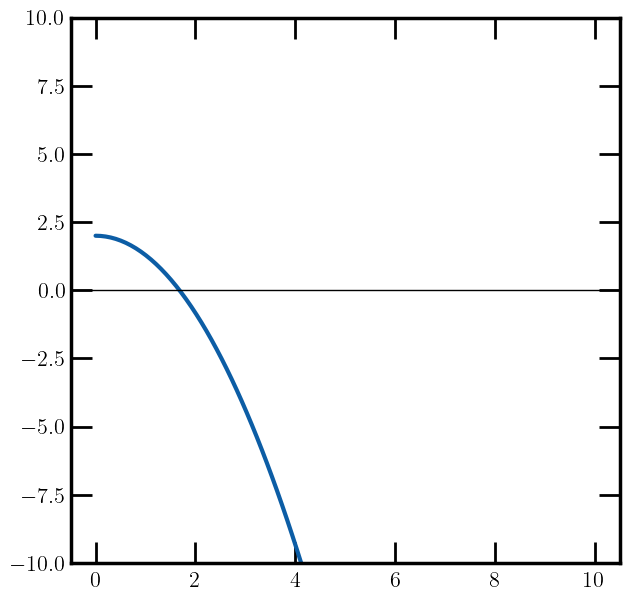

In [136]:
# Construct the Toeplitz matrix
def construct_toeplitz_matrix(c_m):

    M = c_m.shape[0] - 1
    T = np.zeros((M + 1, M  + 1))

    for i in range(M + 1):
        for j in range(M + 1):
            if i > j:
                T[i, j] = c_m[i - j]
            if i < j:
                T[i, j] = c_m[j - i].conjugate()
            if i == j:
                T[i, j] = 2 * c_m[0]

    return T

def min_eigenvalue(matrix):
    return np.min(np.linalg.eigvals(matrix))

# Check if the Toeplitz matrix is positive definite (all eigenvalues are positive)
def is_valid_toeplitz(c_m):
    
    toeplitz_matrix = construct_toeplitz_matrix(c_m)
    eigvals = np.linalg.eigvals(toeplitz_matrix)
    if np.all(eigvals.real > 0):
        return True
    else:
        return False
    
# Plot the min eigenvalue as a function of t
ts = np.linspace(0, 10, 100)
min_eigenvalues = np.zeros_like(ts)
for i, t in enumerate(ts):
    c_m = collapse_2d_coeffs(t, c_mn_reduced)
    min_eigenvalues[i] = min_eigenvalue(construct_toeplitz_matrix(c_m))

fig, ax = newplot('full')
ax.plot(ts, min_eigenvalues)

plt.ylim(-10, 10)
plt.axhline(0, color='black', lw=1)

In [142]:
# Function to go from the right half plane to the unit disk
def cayley_transform(z):
    return (z - 1) / (z + 1)

# Function to go from the unit disk to the right half plane
def cayley_transform_inv(z):
    return (z + 1) / (1 - z)

phi = lambda z: cayley_transform(eval(z, c_m_reduced))


print(phi(1.0).conjugate())

def construct_next_schur_function(phi):

    gamma = phi(0)

    def next_schur_function(z):
        return (phi(z) - gamma) / (1 - gamma.conjugate() * phi(z)) / z
    return next_schur_function


def construct_schur_numbers(phi, N):

    schur_numbers = np.zeros(N, dtype=np.complex)
    schur_numbers[0] = phi(0)

    next_schur_function = construct_next_schur_function(phi)

    for i in range(1, N):
        schur_numbers[i] = next_schur_function(0)
        next_schur_function = construct_next_schur_function(next_schur_function)

    return schur_numbers

print(construct_schur_numbers(phi, 3))

-0.33333334


/tmp/ipykernel_4230/750112311.py:25: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  schur_numbers = np.zeros(N, dtype=np.complex)


[ 0.+0.j nan+0.j nan+0.j]


In [138]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap

# -------------------------
# Series arithmetic helpers
# -------------------------
def series_multiply(a, b, order):
    """
    Multiply two power series a(z) and b(z), given as arrays of coefficients,
    and return the product series truncated to the given order.
    """
    return jnp.convolve(a, b)[:order]

def series_inverse(b, order):
    """
    Compute the power-series inverse of b(z) (an array of coefficients) up to the given order.
    Assumes b[0] is nonzero.
    """
    c = jnp.zeros(order, dtype=b.dtype)
    c = c.at[0].set(1.0 / b[0])
    for n in range(1, order):
        s = 0.0 + 0.0j
        for k in range(1, n+1):
            if k < b.shape[0]:
                s += b[k] * c[n - k]
        c = c.at[n].set(-s / b[0])
    return jnp.nan_to_num(c)

def series_divide(a, b, order):
    """
    Compute the power-series quotient a(z)/b(z) up to the given order.
    """
    b_inv = series_inverse(b, order)
    return series_multiply(a, b_inv, order)

# -------------------------
# Cayley transform for f <-> φ
# -------------------------
def caratheodory_from_schur(phi):
    """
    Return f(z) = (1+phi(z))/(1-phi(z)).
    """
    return (1 + phi) / (1 - phi)

def compute_phi_series(f_coeffs, order):
    """
    Given the Taylor series for f(z)=1+c₁z+c₂z²+… (with f(0)=1),
    compute the Taylor series for φ(z) = (f(z)-1)/(f(z)+1) up to the given order.
    """
    # f - 1:
    f_minus = f_coeffs.copy()
    f_minus = f_minus.at[0].set(f_coeffs[0] - 1.0)
    # f + 1:
    f_plus = f_coeffs.copy()
    f_plus = f_plus.at[0].set(f_coeffs[0] + 1.0)
    return series_divide(f_minus, f_plus, order)

# -------------------------
# Schur algorithm: extract parameters
# -------------------------
def compute_schur_parameters(phi_coeffs, max_iter):
    """
    Given the Taylor series for φ(z) (with φ(0)=γ₀),
    extract Schur parameters by applying the Schur algorithm.
    
    Recursion:
        φ₀(z) = φ(z),
        γₖ = φₖ(0),
        φₖ₊₁(z) = (φₖ(z) - γₖ) / (z (1 - overline(γₖ) φₖ(z))).
    """
    params = []
    current = phi_coeffs
    current_order = len(phi_coeffs)
    for i in range(max_iter):
        gamma = current[0]
        params.append(gamma)
        if current_order <= 1:
            break
        gamma_series = jnp.zeros(current_order, dtype=current.dtype)
        gamma_series = gamma_series.at[0].set(gamma)
        numerator = current - gamma_series
        # Denom: 1 - conjugate(gamma)*current(z)
        denom = jnp.concatenate((
            jnp.array([1.0 - jnp.conjugate(gamma) * current[0]], dtype=current.dtype),
            -jnp.conjugate(gamma) * current[1:]
        ))
        Q = series_divide(numerator, denom, current_order)
        new_order = current_order - 1
        if new_order <= 0:
            break
        current = Q[1:current_order]
        current_order = new_order
    return params

# -------------------------
# Reconstruct φ (and hence f) from Schur parameters and a free tail ψ.
# -------------------------
def build_phi_from_schur(z, schur_params, psi):
    """
    Given Schur parameters [γ₀, γ₁, ..., γₙ₋₁] and a free tail ψ,
    reconstruct φ(z) via the backward recursion:
         φ(z) = (γ₀ + z φ₁(z))/(1 + overline(γ₀) z φ₁(z))
         ...
         with φₙ₋₁(z) = (γₙ₋₁ + z ψ(z))/(1 + overline(γₙ₋₁) z ψ(z)).
    """
    phi_val = psi
    for gamma in reversed(schur_params):
        phi_val = (gamma + z * phi_val) / (1 + jnp.conjugate(gamma) * z * phi_val)
    return phi_val

def f_from_phi(phi):
    """
    Recover f(z) from φ(z) via f(z) = (1+φ(z))/(1-φ(z)).
    """
    return (1 + phi) / (1 - phi)

# -------------------------
# Main completion function
# -------------------------
# @jit
def complete_f(z, f_coeffs, psi, order, max_iter):
    """
    Given:
      - f_coeffs: known Taylor coefficients for f(z)=1+c₁z+c₂z²+… (with f(0)=1)
      - psi: a free Schur function (the “tail”); here it may be chosen as a constant.
      - order: the number of series coefficients to use,
      - max_iter: the number of Schur parameters to extract,
    returns f(z) computed from the parameterization.
    """
    phi_series = compute_phi_series(f_coeffs, order)
    schur_params = compute_schur_parameters(phi_series, max_iter)
    phi_z = build_phi_from_schur(z, schur_params, psi)
    return f_from_phi(phi_z)

# ============================
# Now: Checking the Result via Code
# ============================

def taylor_coefficients(f, order, x0=0.0):
    coeffs = [f(x0)]
    deriv = f
    for n in range(1, order):
        deriv = jax.jacfwd(deriv)
        # For a scalar-to-scalar function, jax.jacfwd returns a function whose output is a scalar.
        coeffs.append(deriv(x0) / np.math.factorial(n))
    return jnp.array(coeffs)


# (B) Check that f(z) maps the disk into the right-half plane.
def check_mapping(f, num_points=50):
    """
    Sample f(z) on a grid in the unit disk and check that Re(f(z)) > 0.
    """
    radii = jnp.linspace(0.0, 0.99, num_points)
    angles = jnp.linspace(0, 2*jnp.pi, num_points, endpoint=False)
    ok = True
    for r in radii:
        for theta in angles:
            z = r * jnp.exp(1j * theta)
            val = f(z)
            if jnp.real(val) <= 0:
                ok = False
                break
        if not ok:
            break
    return ok

# -------------------------
# Example usage:
# -------------------------
# Suppose the known Taylor series for f(z) is:
#    f(z) = 1 + 0.2 z - 0.1 z^2 + 0.05 z^3.
# (i.e. f(0)=1)
f_known = jnp.array([1.0, 0.2, -0.1], dtype=jnp.complex64)
order = f_known.shape[0]   # Number of coefficients to use.
max_iter = order           # Extract as many Schur parameters as available.

# Choose a free tail psi.
# Here, we choose psi = 0 so that the completion exactly recovers the given data.
psi = 0.5 + 0.0j

# Wrap the complete_f function to obtain a function f_new(z).
@jit
def f_new(z):
    return complete_f(z, f_known, psi, order, max_iter)


print(f_new(1.0 + 0.0j))

# (1) Check the new Taylor series by sampling on a small circle around 0.
taylor_coeffs_new = taylor_coefficients(f_new, order + 2)
print("Known f coefficients:")
print(f_known)
print("\nReconstructed f coefficients (via FFT sampling):")
print(taylor_coeffs_new)

# (2) Check that f(z) maps the unit disk to the right-half plane.
mapping_ok = check_mapping(f_new, num_points=50)
print("\nMapping to right-half plane (should be True):", mapping_ok)

# (3) (Optional) Evaluate f(z) at a sample point.
z_sample = 0.5 + 0.0j
print("\nf(z) at z = 0.5:", f_new(z_sample))

# f' = c0 + c1 z + c2 z2  + z^M+1 * Phi


(3.2476184+0j)
Known f coefficients:
[ 1. +0.j  0.2+0.j -0.1+0.j]

Reconstructed f coefficients (via FFT sampling):
[ 1.        +0.j  0.2       +0.j -0.09999999+0.j  0.9636364 +0.j
  0.2427686 +0.j]

Mapping to right-half plane (should be True): True

f(z) at z = 0.5: (1.2151898+0j)


In [23]:
# plot f and f_new

import matplotlib.pyplot as plt

z = jnp.linspace(0, 1, 500)
f_vals = vmap(f_new)(z)

plt.figure(figsize=(8, 8))
plt.plot(z, jnp.real(f_vals), label="Re[f(z)]")
plt.xlabel("$\alpha$")

Text(0.5, 0, '$\x07lpha$')

Error in callback <function _draw_all_if_interactive at 0x7d055ebcadc0> (for post_execute):


ValueError: 
$lpha$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$lpha$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 800x800 with 1 Axes>

In [149]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap

# ========= Helper: Build f_coeffs from a 2D matrix ==========

def compute_f_coeffs(t, c_mn):
    """
    Given a 2D array c_mn of shape (order, poly_order) such that for m>=1,
         c_m(t) = sum_{n=0}^{poly_order-1} c_mn[m, n] * t^n,
    return the Taylor coefficients [c_0(t), c_1(t), c_2(t), ..., c_{order-1}(t)].
    
    Parameters:
      t: a scalar parameter.
      c_mn: a 2D jax.numpy array with shape (order, poly_order). (For m = 0 the row is ignored.)
    """
    order, poly_order = c_mn.shape
    coeffs = []  # f(0)

    powers = t ** jnp.arange(poly_order)  # [t^0, t^1, ..., t^(poly_order-1)]

    for m in range(0, order):
        coeff_m = jnp.sum(c_mn[m, :] * powers)
        coeffs.append(coeff_m)
    # print("coeffs = ", coeffs)
    return jnp.array(coeffs)

# ========= (Re)use the previous completion machinery =========
# (We assume these functions are already defined.)

def series_multiply(a, b, order):
    return jnp.convolve(a, b)[:order]

def series_inverse(b, order):

    tol = 1e-14

    def zero_case(_):
        return jnp.zeros(order, dtype=b.dtype)

    def nonzero_case(_):
        c = jnp.zeros(order, dtype=b.dtype)
        c = c.at[0].set(1.0 / b[0])
        for n in range(1, order):
            s = 0.0 + 0.0j
            for k in range(1, n+1):
                if k < b.shape[0]:
                    s += b[k] * c[n - k]
            c = c.at[n].set(-s / b[0])
        return c
    
    return jax.lax.cond(jnp.abs(b[0]) < tol, zero_case, nonzero_case, None)

def series_divide(a, b, order):
    b_inv = series_inverse(b, order)
    # print("inv = ", b_inv)
    return series_multiply(a, b_inv, order)

def caratheodory_from_schur(phi):
    return (1 + phi) / (1 - phi)

def compute_phi_series(f_coeffs, order):
    f_minus = f_coeffs.copy()
    f_minus = f_minus.at[0].set(f_coeffs[0] - 1.0)
    f_plus = f_coeffs.copy()
    f_plus = f_plus.at[0].set(f_coeffs[0] + 1.0)
    return series_divide(f_minus, f_plus, order)

def compute_schur_parameters(phi_coeffs, max_iter):
    params = []
    current = phi_coeffs
    current_order = len(phi_coeffs)
    for i in range(max_iter):
        gamma = current[0]
        params.append(gamma)
        if current_order <= 1:
            break
        gamma_series = jnp.zeros(current_order, dtype=current.dtype)
        gamma_series = gamma_series.at[0].set(gamma)
        numerator = current - gamma_series
        denom = jnp.concatenate((
            jnp.array([1.0 - jnp.conjugate(gamma) * current[0]], dtype=current.dtype),
            -jnp.conjugate(gamma) * current[1:]
        ))
        # print(f"iter {i}")
        # print(f"numerator = {numerator}")
        # print(f"denom = {denom}")
        Q = series_divide(numerator, denom, current_order)
        new_order = current_order - 1
        if new_order <= 0:
            break
        current = Q[1:current_order]
        current_order = new_order
    return params

def build_phi_from_schur(z, schur_params, psi):
    phi_val = psi
    for gamma in reversed(schur_params):
        phi_val = (gamma + z * phi_val) / (1 + jnp.conjugate(gamma) * z * phi_val)
    return phi_val

def f_from_phi(phi):
    return (1 + phi) / (1 - phi)

# @jit
def complete_f(z, f_coeffs, psi, order, max_iter):
    phi_series = compute_phi_series(f_coeffs, order)
    schur_params = compute_schur_parameters(phi_series, max_iter)
    phi_z = build_phi_from_schur(z, schur_params, psi)
    return f_from_phi(phi_z)

# ========= Combining t and z =========

# Suppose you have a matrix c_mn.
# For example, let order = 4 (so f(z) = 1 + c_1 z + c_2 z^2 + c_3 z^3)
# and let the polynomial in t have degree poly_order = 3.
order = 4
poly_order = 3

# Create a 2D matrix of coefficients (for m = 0, this row is ignored since f(0)=1).
# Here we use some example numbers.
c_mn = jnp.array([
    [1.0, 0.0, 0.0, 0.0],      # row for m=0 (ignored)
    [0.0, 0.0, -0.0, 0.0],   # c_1(t) = 0.2 + 0.01*t - 0.005*t^2
    [-0.0, 0.00, -0.0, 0.0],   # c_2(t) = -0.1 + 0.02*t + 0.001*t^2
    # [0.00, -0.01, 0.002]   # c_3(t) = 0.05 - 0.01*t + 0.002*t^2
], dtype=jnp.float32)

# We also choose a free tail psi. For simplicity, we take it as a constant.
psi = 0.0 + 0.0j

# We now define a function that for a given t returns f(t,z) (for a fixed z)

# @jit
def f_tz(t, z):
    # Compute the Taylor coefficients for this t:
    f_coeffs_t = compute_f_coeffs(t, c_mn)
    # Then compute f(z) using our completion procedure.
    return complete_f(z, f_coeffs_t, psi, order, max_iter=order)

print("f(0.5, 0.5) =", f_tz(0.5, 0.5))

# Optionally, vectorize over t:
f_tz_vmap = vmap(lambda t: f_tz(t, z=0.5+0j))

# === Example usage ===
# Let t vary over a few sample values:
t_values = jnp.linspace(0.0, 1.0, 5)
f_values = f_tz_vmap(t_values)
print("t values:", t_values)
print("f(t, 0.5) values:", f_values)


f(0.5, 0.5) = (1+0j)
t values: [0.   0.25 0.5  0.75 1.  ]
f(t, 0.5) values: [1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]


In [150]:
f_coeffs = compute_f_coeffs(0.5, c_mn)
phi_coeffs = compute_phi_series(f_coeffs, order)
schur_parameters = compute_schur_parameters(phi_coeffs, max_iter=order)

print("f_coeffs = ", f_coeffs)
print("phi_coeffs = ", phi_coeffs)
print("schur_parameters = ", schur_parameters)

f_coeffs =  [1. 0. 0.]
phi_coeffs =  [0. 0. 0. 0.]
schur_parameters =  [Array(0., dtype=float32), Array(0., dtype=float32), Array(0., dtype=float32), Array(0., dtype=float32)]


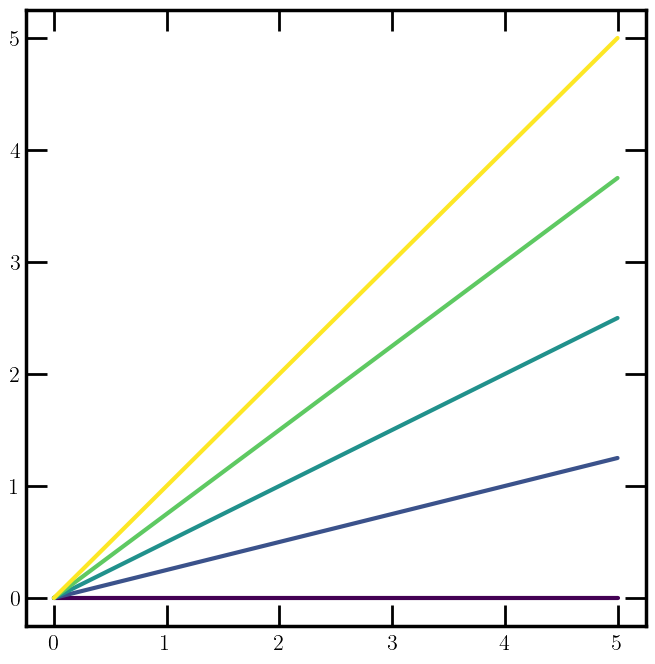

In [151]:
# plot f(t, z) as a function of t for a few z values

import matplotlib.pyplot as plt

t = jnp.linspace(0.0, 5.0, 500)
z_values = jnp.linspace(0, 1, 5)

plt.figure(figsize=(8, 8))

for z in z_values:
    f_vals = vmap(lambda t: f_tz(t, z))(t)
    plt.plot(t, z * t *jnp.real(f_vals), label=f"Re[f(t, {z})]", color = plt.cm.viridis(z))

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap

# ========================================================
# 1. Build t-dependent Taylor coefficients from a 2D matrix
# ========================================================

def compute_f_coeffs(t, c_mn):
    """
    Given a 2D array c_mn of shape (order, poly_order) such that for m>=1,
         c_m(t) = sum_{n=0}^{poly_order-1} c_mn[m, n] * t^n,
    and with f(0)=1,
    return the Taylor coefficients [1, c_1(t), c_2(t), ..., c_{order-1}(t)].
    """
    order, poly_order = c_mn.shape
    coeffs = [1.0]  # f(0)=1 is fixed.
    for m in range(1, order):
        powers = t ** jnp.arange(poly_order)  # [t^0, t^1, ..., t^(poly_order-1)]
        coeff_m = jnp.sum(c_mn[m, :] * powers)
        coeffs.append(coeff_m)
    return jnp.array(coeffs)

# Example: Let order=4 (i.e. f(z)=1+c_1z+c_2z^2+c_3z^3)
# and let each c_m(t) be a polynomial of degree <3.
order = 4
poly_order = 3

# For m>=1, we provide an example 2D matrix c_mn.
# Row 0 is ignored (since f(0)=1); the following rows define c_1(t), c_2(t), c_3(t)
c_mn = jnp.array([
    [0.0,  0.0,    0.0   ],   # m=0 (ignored)
    [0.2,  0.01,  -0.005],   # c_1(t) = 0.2 + 0.01*t - 0.005*t^2
    [-0.1, 0.02,   0.001],   # c_2(t) = -0.1 + 0.02*t + 0.001*t^2
    [0.05, -0.01,  0.002]    # c_3(t) = 0.05 - 0.01*t + 0.002*t^2
], dtype=jnp.float32)

# ========================================================
# 2. Construct the Carathéodory–Toeplitz matrix from f_coeffs
# ========================================================

def caratheodory_toeplitz_matrix(f_coeffs):
    """
    Given a vector f_coeffs = [f0, f1, ..., f_N] with f0=1,
    construct the (N+1) x (N+1) Carathéodory–Toeplitz matrix T:
    
       T[i,j] = 
         2             if i == j,
         f_{|i-j|}     if i != j.
    
    (This is one classical formulation; note that different authors use slightly
     different normalizations.)
    """
    N = len(f_coeffs) - 1
    T = jnp.zeros((N+1, N+1), dtype=f_coeffs.dtype)
    for i in range(N+1):
        for j in range(N+1):
            if i == j:
                T = T.at[i, j].set(2.0)
            else:
                T = T.at[i, j].set(f_coeffs[abs(i - j)])
    return T

def solution_exists_for_t(t, c_mn, tol=1e-6):
    """
    For a given t, compute the Taylor coefficients f_coeffs and then
    the corresponding Carathéodory–Toeplitz matrix. Check if all eigenvalues
    of this matrix are >= -tol. If yes, then the given data is feasible.
    Returns a tuple (exists, min_eig) where exists is a boolean and min_eig is the smallest eigenvalue.
    """
    f_coeffs = compute_f_coeffs(t, c_mn)
    T = caratheodory_toeplitz_matrix(f_coeffs)
    eigs = jnp.linalg.eigvals(T)
    min_eig = jnp.min(jnp.real(eigs))
    exists = min_eig > -tol  # allow a little tolerance for numerical errors
    return exists, min_eig

# ========================================================
# 3. Test the feasibility over a range of t
# ========================================================

# We check for t in the interval [0, 1]
t_values = jnp.linspace(0.0, 1.0, 20)

# Vectorize the solution_exists_for_t check over t.
solution_exists_vmap = vmap(lambda t: solution_exists_for_t(t, c_mn, tol=1e-6))
exists_flags, min_eigs = solution_exists_vmap(t_values)

print("t-values:\n", t_values)
print("Feasibility flags (True means a solution exists):\n", exists_flags)
print("Minimum eigenvalues of the Carathéodory–Toeplitz matrices:\n", min_eigs)

# ========================================================
# (Optional) 4. An alternative check via Schur parameters
# ========================================================
#
# One may also compute the Schur parameters from the Cayley transform of f.
# (If any Schur parameter has |γ| >= 1, the data cannot come from a Carathéodory function.)
#
# For example, suppose we already have a function compute_phi_series and
# compute_schur_parameters (as in previous examples). Then one could do:
#
# def schur_check(f_coeffs, max_iter):
#     phi_series = compute_phi_series(f_coeffs, len(f_coeffs))
#     schur_params = compute_schur_parameters(phi_series, max_iter)
#     # Check if all |γ| < 1:
#     return all(jnp.abs(gamma) < 1 - 1e-6 for gamma in schur_params)
#
# And one would then loop over t-values as above.


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


t-values:
 [0.         0.05263158 0.10526316 0.15789473 0.21052632 0.2631579
 0.31578946 0.36842105 0.42105263 0.47368422 0.5263158  0.57894737
 0.6315789  0.68421054 0.7368421  0.7894737  0.84210527 0.8947368
 0.94736844 1.        ]
Feasibility flags (True means a solution exists):
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Minimum eigenvalues of the Carathéodory–Toeplitz matrices:
 [1.5657669 1.5661719 1.5666217 1.5671138 1.5676506 1.5682318 1.5688586
 1.569528  1.5702416 1.5710008 1.5718049 1.5726513 1.5735422 1.5744786
 1.57546   1.5764866 1.5775573 1.5786726 1.579833  1.581038 ]
